## CUNY MSDA Fall 2017 Semester
### DATA 620
### Week 6 Homework Assigment: The Southern Women Data Set
By Dmitriy Vecheruk

**Assignment**  

Here is a dataset that shows a simple 2-node network:  the attendance of 18 Southern Women at 14 social events:
  
Dataset: http://vlado.fmf.uni-lj.si/pub/networks/data/Ucinet/davis.dat  
Python code to create dataset: https://networkx.readthedocs.io/en/stable/examples/algorithms/davis_club.html  
What can you infer about the relationships between (1) the women, and (2) the social events?  

----
**Solution**

###  1. Load the dataset 
using the networkx built-in function [1]

In [203]:
import networkx as net
import networkx.algorithms.bipartite as bipartite
import numpy as np

%matplotlib inline

In [204]:
# Function to compute graph metrics

def compute_graph_metrics(g):

    node_cnt = g.number_of_nodes()
    edge_cnt = len(g.edges())
    neighbor_cnts = [len(g.neighbors(node)) for node in g.nodes()]
    
    return dict(
    node_cnt = node_cnt,
    edge_cnt = edge_cnt,
    avg_degree = sum(neighbor_cnts)/len(neighbor_cnts),
    min_degree = min(neighbor_cnts),
    max_degree = max(neighbor_cnts),
    diameter = net.algorithms.diameter(g)
    )

In [205]:
G = net.davis_southern_women_graph()

In [206]:
G.graph.viewitems()

dict_items([('top', ['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Frances Anderson', 'Eleanor Nye', 'Pearl Oglethorpe', 'Ruth DeSand', 'Verne Sanderson', 'Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd', 'Dorothy Murchison', 'Olivia Carleton', 'Flora Price']), ('bottom', ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14'])])

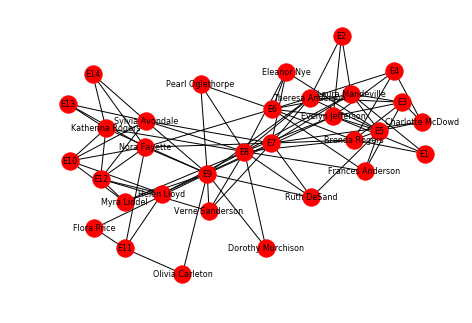

In [207]:
net.draw_spring(G, with_labels = True,font_size=8)

We can see that this bipartite graph has two types of nodes:  
  
* 'top' nodes with women names
* 'bottom' nodes with coded events

From the visualization it is clear that some events (E6, E7, E8) were attended by many more women than others (E1, E11).

### 2. Investigate the relationships between women
  
Using the code in the documentation for networkx [1], we can project the graph onto the 'top' nodes only building an edge when two women attended the same event. Thus we can explore the affiliations between the women.  
  
The weight of the edge will equal the ratio of events the women attended in common vs. the total possible shared events: e.g. if one woman attended two events, and another three, out of which they share one event, the weight of the edge would be equal to 1/min(2,3)= 1/2 [2]

In [208]:
women = G.graph['top']

W = bipartite.weighted_projected_graph(G, women,ratio=True)

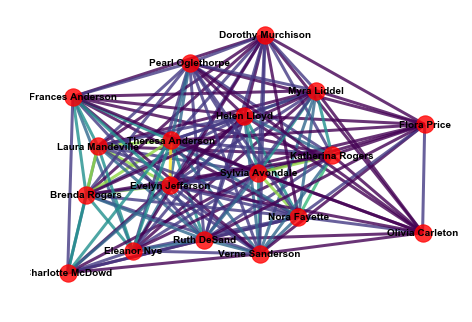

In [209]:
# Draw plot with edge weight mapped to color
# Based on: https://stackoverflow.com/a/16544157/8066374

def draw_weighted_graph(g,pos,weight_name):
    """
    Draws a graph with edges colored according to the weight_name edge attribute
    Based on: https://stackoverflow.com/a/16544157/8066374
    """
    edges,colors = zip(*net.get_edge_attributes(g,weight_name).items())

    net.draw(g,pos = pos,edgelist=edges,edge_color=colors,width=3,alpha=.8,
             with_labels = True,font_size=10,font_family='Arial',font_weight='bold');
    
pos = net.spring_layout(W)
draw_weighted_graph(W,pos,'weight')

In [210]:
print compute_graph_metrics(W)

{'diameter': 2, 'edge_cnt': 139, 'avg_degree': 15, 'node_cnt': 18, 'min_degree': 11, 'max_degree': 17}


We can see that the graph of affiliations among women is very well-connected, with each woman related to at least 11 out of 17 remaining women.  
But not all of the relationships are equally strong.    
  
By isolating the parts of the graph with the above-average edge weight we will possibly see groups of friends that could know each other personally (due to the above-average similarity in their event attendance):   

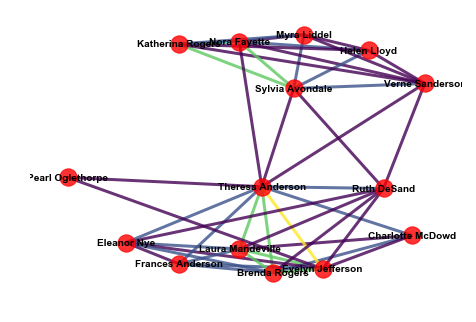

In [211]:
# Draw filtered plot with edge weight mapped to color
weights = net.get_edge_attributes(W,'weight').values()
avg_wt = sum(weights)/len(weights)

w_friends = ((u,v,d) for u,v,d in W.edges_iter(data=True) if d['weight']>avg_wt)
W_friends = net.Graph()
W_friends.add_edges_from(w_friends)

pos = net.spring_layout(W_friends)
draw_weighted_graph(W_friends,pos,'weight')

We can now see two well-connected clusters of people with stronger ties, with Ms. Theresa Anderson, Ms. Sylvia Avondale, and Ms. Ruth DeSand acting as well-connected boundary spanners based on the co-participation in social events. 

### 3. Investigate the relationships between the events
  
Now we will project the graph onto the event nodes using the same approach: the more women co-attend the event, the more affiliated the events are, so the edge generated between them will receive a higher weight (as above).

In [212]:
events = G.graph['bottom']

E = bipartite.weighted_projected_graph(G, events,ratio=True)

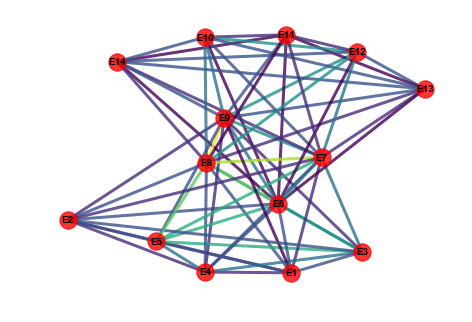

In [213]:
pos = net.spring_layout(E)
draw_weighted_graph(E,pos,'weight')

In [214]:
e_graph_metrics = compute_graph_metrics(E)
print e_graph_metrics

{'diameter': 2, 'edge_cnt': 66, 'avg_degree': 9, 'node_cnt': 14, 'min_degree': 8, 'max_degree': 13}


We can see that the events graph is also highly connected, with a minimum degree of 8, indicating that even the least popular event shares the attendees with 8 other events.
  
Calculating the degree centrality we can find out which events are the most and least popular, and looking at the highest-weighted edges we can see which events are the most similar in terms of the people attending them.  

In [215]:
E_degree = E.degree()
most_popular_events = [k for k,v in d.items() if v == e_graph_metrics['max_degree']]
least_popular_events = [k for k,v in d.items() if v == e_graph_metrics['min_degree']]
print "The most popular events are: {} \nThe least popular events are: {}".format(most_popular_events,
                                                                                   least_popular_events)

The most popular events are: ['E9', 'E8', 'E7', 'E6'] 
The least popular events are: ['E11', 'E10', 'E13', 'E12', 'E14', 'E5', 'E4', 'E1', 'E3', 'E2']


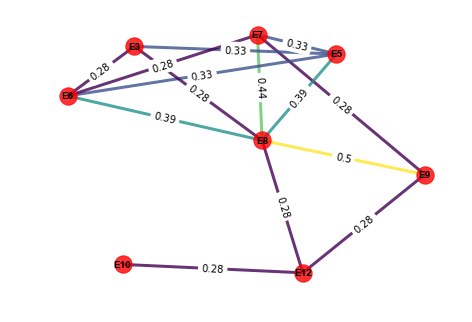

In [216]:
e_weights = net.get_edge_attributes(E,'weight').values()
e_top10_weight_border = sorted(e_weights)[-10] # minimum weight of the top 10 edge weights

e_similar = ((u,v,d) for u,v,d in E.edges_iter(data=True) if d['weight']>=e_top10_weight_border)
E_similar = net.Graph()
E_similar.add_edges_from(e_similar)

#draw_weighted_graph(E_similar,'weight')


pos=net.spring_layout(E_similar)
draw_weighted_graph(E_similar,pos,'weight')
labels = net.get_edge_attributes(E_similar,'weight')
labels = {k:round(v,2) for k, v in labels.items()}
net.draw_networkx_edge_labels(E_similar,pos,edge_labels=labels);

We can see that all of the four most popular events: E6, E7, E7, and E9 are also among the top 10 most similar event relationships based on the similarity in their attendants. Although less popular based on the degree, the event E5 seems to be also highly similar to E6, E7, and E8 in this regrard.

### Reference
1) [Davis Club - NetworkX 1.10 Documentation](https://networkx.github.io/documentation/networkx-1.10/examples/algorithms/davis_club.html)  
2) Borgatti, S.P. and Halgin, D. In press. “Analyzing Affiliation Networks”. In Carrington, P. and Scott, J. (eds) The Sage Handbook of Social Network Analysis. Sage Publications [[pdf]](http://www.steveborgatti.com/research/publications/bhaffiliations.pdf?attredirects=0&d=1)  
3) https://stackoverflow.com/questions/3950897/networkx-how-to-draw-coloured-edges  
4) https://stackoverflow.com/questions/27518016/apply-function-on-all-values-of-dictionary